# Amazon SageMaker Autopilot demo on a popular kaggle.com challenge: "Titanic: Machine Learning from Disaster"

For more info please visti the Titanic challenge officila webpage https://www.kaggle.com/c/titanic In this demo we are going to use only Titanic training set in order to validate the accuracy of autopilot binary classification

**Data Dictionary** of the 891 passengers available in the Titanic training set.

- **survival** Survival (0 = No, 1 = Yes)  <font color='green'>  --> Target variable!</font>
- **pclass** Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- **sex** Sex
- **Age** Age in years
- **sibsp** # of siblings / spouses aboard the Titanic
- **parch** # of parents / children aboard the Titanic
- **ticket** Ticket number
- **fare** Passenger fare
- **cabin** Cabin number
- **embarked** Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)


## Prerequisites

In [43]:
import sagemaker
import boto3
from sagemaker import get_execution_role
import pandas as pd
#import s3fs
from time import gmtime, strftime, sleep
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
import seaborn as sn
import datetime
import pytz

region = boto3.Session().region_name

session = sagemaker.Session()
bucket = session.default_bucket()
prefix = 'titanic'

role = get_execution_role()

sm = boto3.Session().client(service_name='sagemaker',region_name=region)

### Read the data into a Pandas data frame and take a look.
For demo purposes, the original training set is divided into a training set (80% of samples) and testing set (remaining 20%)

In [2]:
!wget -N https://raw.githubusercontent.com/brego81/SageMaker-Autopilot-Titanic/main/Titanic_train.csv
df_data = pd.read_csv('./Titanic_train.csv')
#df_data = pd.read_csv('s3://{}/{}/train.csv'.format(bucket,prefix))

df_train = df_data.sample(frac=0.8,random_state=10)
df_test = df_data.drop(df_train.index)
df_test_data_no_target = df_test.drop(columns=['Survived'])

print("*** TRAIN ***")
print(df_train.head())
print("\n\n*** TEST ***")
print(df_test_data_no_target.head())


## Upload the dataset to Amazon S3 ##
train_file = 'train_data.csv';
df_train.to_csv(train_file, index=False, header=True)
train_data_s3_path = session.upload_data(path=train_file, key_prefix=prefix + "/train")
print('Train data uploaded to: ' + train_data_s3_path)

test_file = 'test_data.csv';
df_test_data_no_target.to_csv(test_file, index=False, header=False)
test_data_s3_path = session.upload_data(path=test_file, key_prefix=prefix + "/test")
print('Test data uploaded to: ' + test_data_s3_path)

--2020-12-09 11:36:03--  https://raw.githubusercontent.com/brego81/SageMaker-Autopilot-Titanic/main/Titanic_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.24.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.24.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61194 (60K) [text/plain]
Saving to: ‘Titanic_train.csv’

Titanic_train.csv   100%[===================>]  59.76K  --.-KB/s    in 0.001s  

Last-modified header missing -- time-stamps turned off.
2020-12-09 11:36:03 (42.4 MB/s) - ‘Titanic_train.csv’ saved [61194/61194]

*** TRAIN ***
     PassengerId  Survived  Pclass  \
590          591         0       3   
131          132         0       3   
628          629         0       3   
195          196         1       1   
230          231         1       1   

                                             Name     Sex   Age  SibSp  Parch  \
590                          Rintamaki, Mr. Matti 

### Optional - let's look at how our features relate to the target

In [73]:
#for column in df_train.select_dtypes(include=['object']).columns:
#    if column != 'Survived':
#        display(pd.crosstab(index=df_train[column], columns=df_train['Survived'], normalize='columns'))


### Optional - now let's look at how our features relate to one another.

In [4]:
#display(df_train.corr())
#pd.plotting.scatter_matrix(df_train, figsize=(12, 12))
#plt.show()

### Setting up the SageMaker Autopilot Job
It is important underlying that for this demo we are imposing the following constraints
- MaxCandidates = 5 
- MaxRuntimePerTrainingJobInSeconds = 60*10 
- MaxAutoMLJobRuntimeInSeconds = 60*90 


In [5]:
input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': 's3://{}/{}/train'.format(bucket,prefix)
        }
      },
      'TargetAttributeName': 'Survived'
    }
  ]

output_data_config = {
    'S3OutputPath': 's3://{}/{}/output'.format(bucket,prefix)
  }
AutoMLJobConfig={
        'CompletionCriteria': {
            'MaxCandidates': 5,
            'MaxRuntimePerTrainingJobInSeconds': 60*10,
            'MaxAutoMLJobRuntimeInSeconds': 60*90
        }}

ProblemType='BinaryClassification'
AutoMLJobObjective={'MetricName': 'Accuracy'}

### Launching the SageMaker Autopilot Job

In [6]:

timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
auto_ml_job_name = 'automl-titanik-' + timestamp_suffix

print('AutoMLJobName: ' + auto_ml_job_name)

AutopilotStartTime = datetime.datetime.now()
sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                      OutputDataConfig=output_data_config,
                      AutoMLJobConfig = AutoMLJobConfig,
                      AutoMLJobObjective = AutoMLJobObjective,
                      ProblemType=ProblemType,
                      RoleArn=role)

AutoMLJobName: automl-titanik-09-11-36-04


{'AutoMLJobArn': 'arn:aws:sagemaker:eu-west-1:108080333481:automl-job/automl-titanik-09-11-36-04',
 'ResponseMetadata': {'RequestId': '650d627c-aec3-4fb8-9c60-d1fce38f6728',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '650d627c-aec3-4fb8-9c60-d1fce38f6728',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '97',
   'date': 'Wed, 09 Dec 2020 11:36:04 GMT'},
  'RetryAttempts': 0}}

### Tracking SageMaker Autopilot job progress

In [7]:
print ('JobStatus - Secondary Status')
print('------------------------------')


describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    
    print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)

JobStatus - Secondary Status
------------------------------
InProgress - Starting
InProgress - Starting
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress 

### Results

In [59]:
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']
best_candidate_name = best_candidate['CandidateName']
#print(best_candidate)
print('\n')
print("CandidateName: " + best_candidate_name)
print("FinalAutoMLJobObjectiveMetricName: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("FinalAutoMLJobObjectiveMetricValue: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))

if AutopilotStartTime.tzinfo == None:
    AutopilotStartTime = pytz.utc.localize(AutopilotStartTime)
execution_time = describe_response['TransformEndTime'] - AutopilotStartTime
execution_time_minutes = round(execution_time.total_seconds() / 60,1)
print("Execution time in minutes: " + str(execution_time_minutes))



CandidateName: tuning-job-1-52fcfe106274404195-004-39f80672
FinalAutoMLJobObjectiveMetricName: validation:accuracy
FinalAutoMLJobObjectiveMetricValue: 0.8309900164604187
Execution time in minutes: 25.5


### Perform batch inference using the best candidate

In [9]:
model_name = 'automl-titanik-model-' + timestamp_suffix

model = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

print('Model ARN corresponding to the best candidate is : {}'.format(model['ModelArn']))

Model ARN corresponding to the best candidate is : arn:aws:sagemaker:eu-west-1:108080333481:model/automl-titanik-model-09-11-36-04


You can use batch inference by using Amazon SageMaker batch transform. The same model can also be deployed to perform online inference using Amazon SageMaker hosting.

In [10]:
transform_job_name = 'automl-titanic-transform-' + timestamp_suffix

transform_input = {
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': 's3://{}/{}/test'.format(bucket,prefix)
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    }

transform_output = {
        'S3OutputPath': 's3://{}/{}/inference-results'.format(bucket,prefix),
    }

transform_resources = {
        'InstanceType': 'ml.m5.4xlarge',
        'InstanceCount': 1
    }

sm.create_transform_job(TransformJobName = transform_job_name,
                        ModelName = model_name,
                        TransformInput = transform_input,
                        TransformOutput = transform_output,
                        TransformResources = transform_resources
)

{'TransformJobArn': 'arn:aws:sagemaker:eu-west-1:108080333481:transform-job/automl-titanic-transform-09-11-36-04',
 'ResponseMetadata': {'RequestId': 'a058e8f9-33fa-4d1b-9a7a-859a203c2c18',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a058e8f9-33fa-4d1b-9a7a-859a203c2c18',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '113',
   'date': 'Wed, 09 Dec 2020 11:57:10 GMT'},
  'RetryAttempts': 0}}

Watch the transform job for completion.

In [11]:
print ('JobStatus')
print('----------')


describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
job_run_status = describe_response['TransformJobStatus']
print (job_run_status)

while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
    job_run_status = describe_response['TransformJobStatus']
    print (job_run_status)
    sleep(30)

JobStatus
----------
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


Now let's view the results of the transform job:

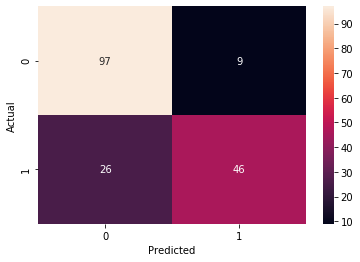

AWS Autopilo accuracy is 80.34% with a trainig time of 25.5 minutes.
Autopilot had the following constraints:


{'MaxCandidates': 5,
 'MaxRuntimePerTrainingJobInSeconds': 600,
 'MaxAutoMLJobRuntimeInSeconds': 5400}

In [72]:
s3_output_key = '{}/inference-results/test_data.csv.out'.format(prefix);
local_inference_results_path = 'inference_results.csv'

s3 = boto3.resource('s3')
inference_results_bucket = s3.Bucket(session.default_bucket())

inference_results_bucket.download_file(s3_output_key, local_inference_results_path);

data = pd.read_csv(local_inference_results_path, sep=';',  header=None)

conf_data = {'y_Actual': df_test.Survived.values  ,
             'y_Predicted': data.values.transpose()[0]}

df = pd.DataFrame(conf_data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()

prediction_accuracy = accuracy_score(conf_data['y_Actual'], conf_data['y_Predicted'])
print('AWS Autopilo accuracy is ' + str(round(prediction_accuracy * 100,2)) + '% with a trainig time of ' + str(execution_time_minutes) + ' minutes.')
print('Autopilot had the following constraints:')
AutoMLJobConfig['CompletionCriteria']


### Candidate Generation Notebook

In [74]:
sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['AutoMLJobArtifacts']['CandidateDefinitionNotebookLocation']

's3://sagemaker-eu-west-1-108080333481/titanic/output/automl-titanik-09-11-36-04/sagemaker-automl-candidates/pr-1-8922ae9cdb2840eebf27921063f3691b2fa3e100d0dc45e4864f28e096/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb'

### Data Exploration Notebook

In [75]:
sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['AutoMLJobArtifacts']['DataExplorationNotebookLocation']

's3://sagemaker-eu-west-1-108080333481/titanic/output/automl-titanik-09-11-36-04/sagemaker-automl-candidates/pr-1-8922ae9cdb2840eebf27921063f3691b2fa3e100d0dc45e4864f28e096/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb'

### Cleanup

In [ ]:
#s3 = boto3.resource('s3')
#bucket = s3.Bucket(bucket)

#job_outputs_prefix = '{}/output/{}'.format(prefix,auto_ml_job_name)
#bucket.objects.filter(Prefix=job_outputs_prefix).delete()